# Regression using the Abalone Dataset

This notebook provides and analysis and results for [this](https://www.kaggle.com/competitions/playground-series-s4e4/overview) Kaggle competition.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
# Loading the data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

## Data cleanup

This dataset has 10 features and the goal is to predict the `Rings` number. The `id` column is not useful so we will drop it in our training datasets as it maps directly to the index.

In [3]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


There are no missing features in this dataset so the cleanup is relatively simple. All we have left to do is label the sex of the abalone has an integer.

In [4]:
train_df.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [5]:
def cleanup_df(df):
    sex_num = df["Sex"].map({"F": 1, "M": -1, "I": 0})
    sex_num = sex_num.rename("Sex_num")
    return pd.concat([df.drop(["Sex", "id"], axis=1), sex_num], axis=1)


train_clean_df = cleanup_df(train_df)
test_clean_df = cleanup_df(test_df)

In [6]:
# Function to convert the predicted array into a submission
def package_result(df, y_out):
    df_out = pd.Series(y_out)
    df_out.index = df["id"]
    df_out.index.name = "id"
    df_out = df_out.rename("Rings")
    return df_out

## Prediction

In [7]:
from sklearn.metrics import root_mean_squared_log_error, make_scorer
from sklearn.model_selection import train_test_split, ValidationCurveDisplay, validation_curve

rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

X_train = train_clean_df.drop("Rings", axis=1)
y_train = train_clean_df["Rings"]

X_test = test_clean_df

X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.3, random_state=42)

We start with a naive Logistic Regression 

In [8]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(C=100, max_iter=2_000)
model_lr.fit(X_train_1, y_train_1)
y_predict_2 = model_lr.predict(X_train_2)

print(root_mean_squared_log_error(y_train_2, y_predict_2))

0.1760267009568668


As expected the Random Forest Regressor works better

In [9]:
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(n_jobs=-1)
model_rfr.fit(X_train_1, y_train_1)
y_predict_2 = model_rfr.predict(X_train_2)

print(root_mean_squared_log_error(y_train_2, y_predict_2))

0.156229775908807


In [10]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(learning_rate=0.1, n_estimators=1000, early_stopping_rounds=5, eval_metric="rmsle", n_jobs=-1)

model_xgb.fit(X_train_1, y_train_1, eval_set=[(X_train_2, y_train_2)])

y_predict_xgb = model_xgb.predict(X_train_2)
error_ref = root_mean_squared_log_error(y_train_2, y_predict_xgb)
print(error_ref)

[0]	validation_0-rmsle:0.27054
[1]	validation_0-rmsle:0.25440
[2]	validation_0-rmsle:0.24028
[3]	validation_0-rmsle:0.22803
[4]	validation_0-rmsle:0.21737
[5]	validation_0-rmsle:0.20810
[6]	validation_0-rmsle:0.19988
[7]	validation_0-rmsle:0.19289
[8]	validation_0-rmsle:0.18695
[9]	validation_0-rmsle:0.18179
[10]	validation_0-rmsle:0.17741
[11]	validation_0-rmsle:0.17370
[12]	validation_0-rmsle:0.17051
[13]	validation_0-rmsle:0.16784
[14]	validation_0-rmsle:0.16546
[15]	validation_0-rmsle:0.16359
[16]	validation_0-rmsle:0.16199
[17]	validation_0-rmsle:0.16056
[18]	validation_0-rmsle:0.15940
[19]	validation_0-rmsle:0.15846
[20]	validation_0-rmsle:0.15763
[21]	validation_0-rmsle:0.15696
[22]	validation_0-rmsle:0.15634
[23]	validation_0-rmsle:0.15587
[24]	validation_0-rmsle:0.15543
[25]	validation_0-rmsle:0.15508
[26]	validation_0-rmsle:0.15479
[27]	validation_0-rmsle:0.15452
[28]	validation_0-rmsle:0.15425
[29]	validation_0-rmsle:0.15401
[30]	validation_0-rmsle:0.15385
[31]	validation_0-

In [11]:
# y_predict_xgb_out = model_xgb.predict(X_test)
# y_predict_xgb_out_df = package_result(test_df, y_predict_xgb_out)
# y_predict_xgb_out_df.round(0).astype("int").to_csv("submissions/xgb_naive_guess.csv")

Let us give another try at hyperparameter tuning.

In [11]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(
    objective="reg:squaredlogerror",
    learning_rate=0.1,
    n_estimators=2000,
    early_stopping_rounds=10,
    eval_metric="rmsle",
    n_jobs=-1,
    subsample=1.0,
)

model_xgb.fit(X_train_1, y_train_1, eval_set=[(X_train_2, y_train_2)])

y_predict_xgb = model_xgb.predict(X_train_2)
error_new = root_mean_squared_log_error(y_train_2, y_predict_xgb)
print((error_new, error_new - error_ref))

[0]	validation_0-rmsle:1.75913
[1]	validation_0-rmsle:1.69831


[2]	validation_0-rmsle:1.63830
[3]	validation_0-rmsle:1.57914
[4]	validation_0-rmsle:1.52085
[5]	validation_0-rmsle:1.46346
[6]	validation_0-rmsle:1.40700
[7]	validation_0-rmsle:1.35149
[8]	validation_0-rmsle:1.29699
[9]	validation_0-rmsle:1.24350
[10]	validation_0-rmsle:1.19108
[11]	validation_0-rmsle:1.13974
[12]	validation_0-rmsle:1.08953
[13]	validation_0-rmsle:1.04048
[14]	validation_0-rmsle:0.99262
[15]	validation_0-rmsle:0.94598
[16]	validation_0-rmsle:0.90060
[17]	validation_0-rmsle:0.85651
[18]	validation_0-rmsle:0.81376
[19]	validation_0-rmsle:0.77236
[20]	validation_0-rmsle:0.73234
[21]	validation_0-rmsle:0.69374
[22]	validation_0-rmsle:0.65659
[23]	validation_0-rmsle:0.62089
[24]	validation_0-rmsle:0.58669
[25]	validation_0-rmsle:0.55399
[26]	validation_0-rmsle:0.52282
[27]	validation_0-rmsle:0.49318
[28]	validation_0-rmsle:0.46509
[29]	validation_0-rmsle:0.43850
[30]	validation_0-rmsle:0.41345
[31]	validation_0-rmsle:0.38997
[32]	validation_0-rmsle:0.36800
[33]	validation_

In [ ]:
# y_predict_xgb_hp = model_xgb.predict(X_test)
# y_predict_xgb_hp_df = package_result(test_df, y_predict_xgb_hp)
# y_predict_xgb_hp_df.round(0).astype("int").to_csv("submissions/xgb_hyperparameter_tuning.csv")

Now what about with some scaling? Would that help the performance?

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

columns_to_rescale = X_train.select_dtypes("float").columns

preprocessor = ColumnTransformer(
    transformers=[("scale", StandardScaler(), columns_to_rescale)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)
preprocessor.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 Index(['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [18]:
X_train_prep = preprocessor.fit_transform(X_train)

X_train_prep_1, X_train_prep_2, y_train_prep_1, y_train_prep_2 = train_test_split(
    X_train_prep, y_train, train_size=0.3, random_state=42
)

In [34]:
model_xgb_scaled = XGBRegressor(
    objective="reg:squaredlogerror",
    learning_rate=0.1,
    n_estimators=2000,
    early_stopping_rounds=10,
    eval_metric="rmsle",
    n_jobs=-1,
    subsample=1.0,
)

model_xgb_scaled.fit(X_train_prep_1, y_train_prep_1, eval_set=[(X_train_prep_2, y_train_prep_2)])

y_predict_xgb_scaled = model_xgb_scaled.predict(X_train_prep_2)

print(root_mean_squared_log_error(y_train_prep_2, y_predict_xgb_scaled))

[0]	validation_0-rmsle:1.75913
[1]	validation_0-rmsle:1.69831
[2]	validation_0-rmsle:1.63830
[3]	validation_0-rmsle:1.57914


[4]	validation_0-rmsle:1.52085
[5]	validation_0-rmsle:1.46346
[6]	validation_0-rmsle:1.40700
[7]	validation_0-rmsle:1.35149
[8]	validation_0-rmsle:1.29699
[9]	validation_0-rmsle:1.24350
[10]	validation_0-rmsle:1.19108
[11]	validation_0-rmsle:1.13974
[12]	validation_0-rmsle:1.08953
[13]	validation_0-rmsle:1.04048
[14]	validation_0-rmsle:0.99262
[15]	validation_0-rmsle:0.94598
[16]	validation_0-rmsle:0.90060
[17]	validation_0-rmsle:0.85651
[18]	validation_0-rmsle:0.81376
[19]	validation_0-rmsle:0.77236
[20]	validation_0-rmsle:0.73234
[21]	validation_0-rmsle:0.69374
[22]	validation_0-rmsle:0.65659
[23]	validation_0-rmsle:0.62089
[24]	validation_0-rmsle:0.58669
[25]	validation_0-rmsle:0.55399
[26]	validation_0-rmsle:0.52282
[27]	validation_0-rmsle:0.49318
[28]	validation_0-rmsle:0.46509
[29]	validation_0-rmsle:0.43850
[30]	validation_0-rmsle:0.41345
[31]	validation_0-rmsle:0.38997
[32]	validation_0-rmsle:0.36800
[33]	validation_0-rmsle:0.34750
[34]	validation_0-rmsle:0.32845
[35]	validatio

In [35]:
print(
    root_mean_squared_log_error(y_train_prep_2, y_predict_xgb_scaled)
    - root_mean_squared_log_error(y_train_2, y_predict_xgb)
)

0.0


The scaling seems to have had absolutely no effect!

Now let's try to treat this as a classification issue!

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoding = LabelEncoder()
label_encoding.fit(y_train)

y_train_1_p = label_encoding.transform(y_train_1)
y_train_2_p = label_encoding.transform(y_train_2)

from xgboost import XGBClassifier

model_xgb_classifier = XGBClassifier(
    objective="multi:softprob",
    num_class=len(y_train.unique()),
    learning_rate=0.1,
    subsample=0.3,
    n_estimators=1000,
    early_stopping_rounds=5,
    n_jobs=-1,
)

model_xgb_classifier.fit(X_train_1, y_train_1_p, eval_set=[(X_train_2, y_train_2_p)])

y_predict_xgb_class = model_xgb_classifier.predict(X_train_2)

[0]	validation_0-mlogloss:3.05152
[1]	validation_0-mlogloss:2.86919


[2]	validation_0-mlogloss:2.73506
[3]	validation_0-mlogloss:2.62672
[4]	validation_0-mlogloss:2.53646
[5]	validation_0-mlogloss:2.46060
[6]	validation_0-mlogloss:2.39561
[7]	validation_0-mlogloss:2.33790
[8]	validation_0-mlogloss:2.28729
[9]	validation_0-mlogloss:2.24188
[10]	validation_0-mlogloss:2.20165
[11]	validation_0-mlogloss:2.16450
[12]	validation_0-mlogloss:2.13149
[13]	validation_0-mlogloss:2.10073
[14]	validation_0-mlogloss:2.07419
[15]	validation_0-mlogloss:2.04932
[16]	validation_0-mlogloss:2.02638
[17]	validation_0-mlogloss:2.00535
[18]	validation_0-mlogloss:1.98625
[19]	validation_0-mlogloss:1.96864
[20]	validation_0-mlogloss:1.95241
[21]	validation_0-mlogloss:1.93768
[22]	validation_0-mlogloss:1.92411
[23]	validation_0-mlogloss:1.91163
[24]	validation_0-mlogloss:1.89987
[25]	validation_0-mlogloss:1.88888
[26]	validation_0-mlogloss:1.87843
[27]	validation_0-mlogloss:1.86909
[28]	validation_0-mlogloss:1.86024
[29]	validation_0-mlogloss:1.85217
[30]	validation_0-mlogloss:1

In [17]:
print(root_mean_squared_log_error(y_train_2_p, y_predict_xgb_class))

0.190965149234135


The classification scheme is also not much more accurate!

## Feature engineering

In [114]:
def get_error_df(X_t, y_t, X_v, y_v):
    model = XGBRegressor(
        objective="reg:squaredlogerror",
        learning_rate=0.1,
        n_estimators=2000,
        early_stopping_rounds=10,
        eval_metric="rmsle",
        n_jobs=-1,
        subsample=1.0,
    )
    model.fit(X_t, y_t, eval_set=[(X_v, y_v)])
    y_p = model.predict(X_v)
    error = root_mean_squared_log_error(y_v, y_p)
    return {"model": model, "prediction": y_p, "error": error}

First let us remember the meaning of each feature (see the description [here](https://archive.ics.uci.edu/dataset/1/abalone))
- Length: Longest shell measurement
- Diameter: measurement perpendicular to length
- Height: height with meat in shell
- Whole weight: whole abalone weight
- Whole weight.1: weight of meat of the abalone
- Whole weight.2: gut weight (after bleeding)
- Shell weight: weight after being dried
- Sex_num: if the abalone is female (1), male (-1) or infant (0)

From the first three, we can estimate a typical area and volumen for the abalone. From the weight features, we can obtain the weight of the blood and the weight of the wet shell.

In [115]:
def feature_engineering(df):
    df_2 = df.copy()
    df_2["Area"] = df_2["Length"] * df_2["Diameter"]

    # Some heights are zero, we fix that by setting them to the minimum
    df_2.loc[df_2["Height"] == 0.0, "Height"] = df_2.loc[df_2["Height"] > 0.0, "Height"].median()
    df_2["Volume"] = df_2["Area"] * df_2["Height"]

    df_2["Abalone density"] = df_2["Whole weight"] / df_2["Volume"]
    df_2["Meat density"] = df_2["Whole weight.1"] / df_2["Volume"]

    df_2["Blood weight"] = df_2["Whole weight.1"] - df_2["Whole weight.2"]
    df_2["Wet shell weight"] = df_2["Whole weight"] - df_2["Whole weight.1"]

    # We cap the value of Blood weight and wet shell weight to zero to handle outliers
    df_2.loc[df_2["Blood weight"] <= 0.0, "Blood weight"] = 0.0
    df_2.loc[df_2["Wet shell weight"] <= 0.0, "Wet shell weight"] = 0.0

    df_2["Ratio meat whole weight"] = df_2["Whole weight.1"] / df_2["Whole weight"]
    df_2["Ratio wet shell whole weight"] = df_2["Wet shell weight"] / df_2["Whole weight"]

    return df_2

In [116]:
train_fe_df = feature_engineering(train_clean_df)
test_fe_df = feature_engineering(test_clean_df)

In [117]:
X_train_fe = train_fe_df.drop("Rings", axis=1)
y_train_fe = train_fe_df["Rings"]

X_test_fe = test_fe_df

X_train_fe_1, X_train_fe_2, y_train_fe_1, y_train_fe_2 = train_test_split(
    X_train_fe, y_train_fe, train_size=0.3, random_state=42
)

In [40]:
output_xgb_fe = get_error_df(X_train_fe_1, y_train_fe_1, X_train_fe_2, y_train_fe_2)

[0]	validation_0-rmsle:1.75911


[1]	validation_0-rmsle:1.69828
[2]	validation_0-rmsle:1.63826
[3]	validation_0-rmsle:1.57908
[4]	validation_0-rmsle:1.52077
[5]	validation_0-rmsle:1.46336
[6]	validation_0-rmsle:1.40688
[7]	validation_0-rmsle:1.35136
[8]	validation_0-rmsle:1.29682
[9]	validation_0-rmsle:1.24331
[10]	validation_0-rmsle:1.19086
[11]	validation_0-rmsle:1.13949
[12]	validation_0-rmsle:1.08925
[13]	validation_0-rmsle:1.04016
[14]	validation_0-rmsle:0.99226
[15]	validation_0-rmsle:0.94558
[16]	validation_0-rmsle:0.90015
[17]	validation_0-rmsle:0.85602
[18]	validation_0-rmsle:0.81320
[19]	validation_0-rmsle:0.77175
[20]	validation_0-rmsle:0.73165
[21]	validation_0-rmsle:0.69296
[22]	validation_0-rmsle:0.65572
[23]	validation_0-rmsle:0.61991
[24]	validation_0-rmsle:0.58559
[25]	validation_0-rmsle:0.55275
[26]	validation_0-rmsle:0.52141
[27]	validation_0-rmsle:0.49158
[28]	validation_0-rmsle:0.46328
[29]	validation_0-rmsle:0.43651
[30]	validation_0-rmsle:0.41125
[31]	validation_0-rmsle:0.38751
[32]	validation_0

In [41]:
y_predict_xgb_fe_out = output_xgb_fe["model"].predict(X_test_fe)
y_predict_xgb_fe_out_df = package_result(test_df, y_predict_xgb_fe_out)
y_predict_xgb_fe_out_df.round(0).astype("int").to_csv("submissions/xgb_feature_engineering.csv")

This performs worse than the basic hyperparameter tuning.

## Deep learning

Now we will try a basic neural network and see how it performs. We will use TensorFlow to create a simple NN with 3 layers of 64 neurons. We also add some Batch dropout and normalization in order to tame the over/underfitting. 

In [12]:
from tensorflow import keras
from keras import layers, callbacks

2024-04-05 22:30:09.580391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 22:30:10.774638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [19]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,  # minimium amount of change to count as an improvement
    patience=30,  # how many epochs to wait before stopping
    restore_best_weights=True,
)
input_shape = [len(X_train_prep_1.columns)]

model = keras.Sequential(
    [
        layers.Input(input_shape),
        layers.BatchNormalization(),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1),
    ]
)


def keras_root_mean_squared_log_error(y_true, y_pred):
    msle = keras.losses.MeanSquaredLogarithmicError()
    return keras.backend.sqrt(msle(y_true, y_pred))


model.compile(
    optimizer="adam",
    loss=keras_root_mean_squared_log_error,
)

Epoch 1/500


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.5560 - val_loss: 0.6230
Epoch 2/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7706 - val_loss: 0.2705
Epoch 3/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4931 - val_loss: 0.2603
Epoch 4/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3605 - val_loss: 0.2490
Epoch 5/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3208 - val_loss: 0.2859
Epoch 6/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2939 - val_loss: 0.2389
Epoch 7/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2879 - val_loss: 0.2449
Epoch 8/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2687 - val_loss: 0.2138
Epoch 9/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2703 - val_loss: 0.2048
Epoch 10/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2564 - val_loss: 0.2169
Epoch 11/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2532 - val_loss: 0.2171
Epoch 12/500
107/107 ━━━━━━━━━━━━━━━━━━━━ 

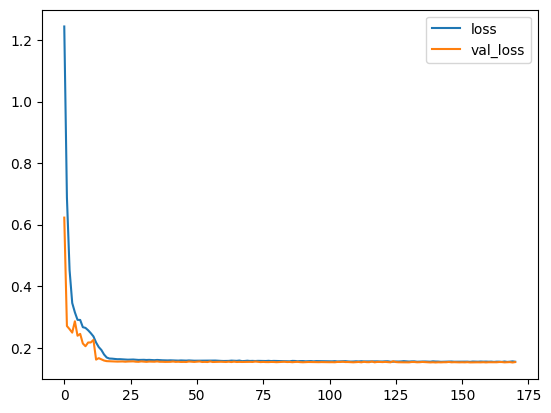

In [20]:
history = model.fit(
    X_train_prep_1,
    y_train_prep_1,
    validation_data=(X_train_prep_2, y_train_prep_2),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping],  # put your callbacks in a list
    verbose=1,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ["loss", "val_loss"]].plot()
print("Minimum validation loss: {}".format(history_df["val_loss"].min()))

In [21]:
y_predict_train_nn = history.model.predict(X_train_prep_2)
error_nn = keras_root_mean_squared_log_error(y_train_prep_2, y_predict_train_nn).numpy()
print((error_nn, error_nn - error_new))

1983/1983 ━━━━━━━━━━━━━━━━━━━━ 2s 750us/step
(0.15258543, 0.0013435482479446648)


In [22]:
y_predict_nn = history.model.predict(X_test)

   1/1888 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step

1888/1888 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [23]:
y_predict_nn = history.model.predict(X_test)[:, 0]
y_predict_nn_df = package_result(test_df, y_predict_nn)
y_predict_nn_df.round(0).astype("int").to_csv("submissions/xgb_neural_network.csv")

1888/1888 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
